# **Predicting flight arrival delays** 

# Necessary libraries & datasets

First, we load all the packages that are needed for the project:

In [1]:
# Standard libraries
import datetime, warnings
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from pprint import pprint

# Applicable sklearn libraries
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

# RandomForest 
from sklearn.ensemble import RandomForestRegressor 

# XGBoost 
from xgboost import XGBRegressor

# CatBoost
from catboost import CatBoostRegressor

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

C:\Users\richa\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


and then, we read the file that contains the details of all the flights that occured in 2015:

In [2]:
df_test = pd.read_csv('data/flights_test.csv')
print('Dataframe dimensions:', df_test.shape)
df_test

Dataframe dimensions: (514384, 17)


,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
0,0,2015,7,1,3,NK,298,N624NK,LAS,IAH,3,41.0,11.0,52.0,177.0,1222,500
1,1,2015,7,1,3,AA,1965,N507AY,SFO,CLT,5,2400.0,21.0,21.0,303.0,2296,808
2,2,2015,7,1,3,DL,2020,N3759,LAX,MEM,5,2400.0,36.0,36.0,223.0,1619,548
3,3,2015,7,1,3,NK,612,N629NK,LAS,MSP,5,53.0,14.0,107.0,178.0,1299,503
4,4,2015,7,1,3,UA,1044,N39418,ANC,ORD,8,17.0,20.0,37.0,364.0,2846,912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514379,514379,2015,7,31,5,DL,919,N835DN,PDX,DTW,2359,2356.0,12.0,8.0,248.0,1953,707
514380,514380,2015,7,31,5,DL,1846,N372DA,PDX,ATL,2359,12.0,10.0,22.0,274.0,2172,733
514381,514381,2015,7,31,5,F9,682,N922FR,DEN,MCO,2359,2355.0,14.0,9.0,213.0,1546,532
514382,514382,2015,7,31,5,F9,300,N951FR,DEN,TPA,2359,4.0,16.0,20.0,204.0,1506,523


In [3]:
df_train = pd.read_csv('data/flights_train.csv')
print('Dataframe dimensions:', df_train.shape)
df_train

Dataframe dimensions: (2818553, 18)


,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2818548,2015,6,30,2,UA,1180,N65832,LAX,ORD,2359,2358.0,11.0,9.0,241.0,1744,600,-8.0
2818549,2818549,2015,6,30,2,UA,1192,N69839,LAX,IAH,2359,129.0,11.0,140.0,201.0,1379,520,79.0
2818550,2818550,2015,6,30,2,UA,1480,N37298,PDX,IAH,2359,152.0,8.0,200.0,249.0,1825,608,107.0
2818551,2818551,2015,6,30,2,UA,1637,N35260,SEA,IAH,2359,12.0,12.0,24.0,250.0,1874,609,9.0


Briefly recall the meaning of the variables that will be used in this notebook:

- **YEAR, MONTH, DAY, DAY_OF_WEEK**: dates of the flight <br/>
- **AIRLINE**: An identification number assigned by US DOT to identify a unique airline <br/>
- **ORIGIN_AIRPORT** and **DESTINATION_AIRPORT**: code attributed by IATA to identify the airports <br/>
- **SCHEDULED_DEPARTURE** and **SCHEDULED_ARRIVAL** : scheduled times of take-off and landing <br/> 
- **DEPARTURE_TIME**: real times at which take-off and landing took place <br/> 
- **ARRIVAL_DELAY**: difference (in minutes) between planned and real times <br/> 
- **DISTANCE**: distance (in miles)  <br/>

An additional file of this dataset, the `airports.csv` and `airlines.csv` file, gives a more exhaustive description of the airports and airlines:

In [4]:
airports = pd.read_csv("data/airports.csv")
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [5]:
airlines = pd.read_csv("data/airlines.csv")
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


___
## 1. Cleaning
___
### 1.1 Filling factor

Examining how complete the dataset is: 

In [6]:
missing_df = df_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)'] = (df_train.shape[0] - missing_df['missing values'])/df_train.shape[0] * 100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)
missing_df

,variable,missing values,filling factor (%)
0,id,0,100.0
1,YEAR,0,100.0
2,MONTH,0,100.0
3,DAY,0,100.0
4,DAY_OF_WEEK,0,100.0
5,AIRLINE,0,100.0
6,FLIGHT_NUMBER,0,100.0
7,TAIL_NUMBER,0,100.0
8,ORIGIN_AIRPORT,0,100.0
9,DESTINATION_AIRPORT,0,100.0


In [7]:
missing_df = df_test.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)'] = (df_test.shape[0] - missing_df['missing values'])/df_test.shape[0] * 100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)
missing_df

,variable,missing values,filling factor (%)
0,id,0,100.0
1,YEAR,0,100.0
2,MONTH,0,100.0
3,DAY,0,100.0
4,DAY_OF_WEEK,0,100.0
5,AIRLINE,0,100.0
6,FLIGHT_NUMBER,0,100.0
7,TAIL_NUMBER,0,100.0
8,ORIGIN_AIRPORT,0,100.0
9,DESTINATION_AIRPORT,0,100.0


Nothing is missing in both sets. 

### 1.2 Data preprocessing


In [8]:
# See the overal distribution of scheduled departure (assuming that has the most effect on the delay)

train = df_train.copy()
test = df_test.copy()
df_res = train.append(test)
df_res

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514379,514379,2015,7,31,5,DL,919,N835DN,PDX,DTW,2359,2356.0,12.0,8.0,248.0,1953,707,NaN
514380,514380,2015,7,31,5,DL,1846,N372DA,PDX,ATL,2359,12.0,10.0,22.0,274.0,2172,733,NaN
514381,514381,2015,7,31,5,F9,682,N922FR,DEN,MCO,2359,2355.0,14.0,9.0,213.0,1546,532,NaN
514382,514382,2015,7,31,5,F9,300,N951FR,DEN,TPA,2359,4.0,16.0,20.0,204.0,1506,523,NaN


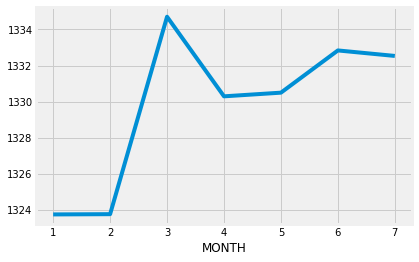

In [9]:
# Checking overal distribution of the mean scheduled departure (important feature in arrival_delay when incorporating in model)

avg_temp = df_res.groupby('MONTH')['SCHEDULED_DEPARTURE'].agg('mean')
avg_temp.plot()
plt.show()

In [10]:
# See which features have a big contribution to the arrival delay and which not within the train dataset

corr_matrix = train.corr()
corr_matrix['ARRIVAL_DELAY'].sort_values(ascending = False)

ARRIVAL_DELAY          1.000000
TAXI_OUT               0.238806
DEPARTURE_TIME         0.164384
WHEELS_OFF             0.160181
SCHEDULED_DEPARTURE    0.103083
SCHEDULED_ARRIVAL      0.092671
FLIGHT_NUMBER          0.017728
MONTH                  0.008731
id                     0.006280
DAY_OF_WEEK           -0.019053
DISTANCE              -0.023849
DAY                   -0.024166
SCHEDULED_TIME        -0.027254
YEAR                        NaN
Name: ARRIVAL_DELAY, dtype: float64

### 1.3 One-hot encoding

In [11]:
variables_to_remove = ['id', 'YEAR', 'TAIL_NUMBER', 'MONTH']

df = df_train.copy()
df.drop(variables_to_remove, axis=1, inplace=True)
print(df.columns)
df

Index(['DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY'],
      dtype='object')


,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,1,4,AS,98,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,1,4,AA,2336,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,1,4,US,840,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,1,4,AA,258,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,1,4,AS,135,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,30,2,UA,1180,LAX,ORD,2359,2358.0,11.0,9.0,241.0,1744,600,-8.0
2818549,30,2,UA,1192,LAX,IAH,2359,129.0,11.0,140.0,201.0,1379,520,79.0
2818550,30,2,UA,1480,PDX,IAH,2359,152.0,8.0,200.0,249.0,1825,608,107.0
2818551,30,2,UA,1637,SEA,IAH,2359,12.0,12.0,24.0,250.0,1874,609,9.0


In [12]:
df.loc[~df.ORIGIN_AIRPORT.isin(airports.IATA_CODE.values),'ORIGIN_AIRPORT'] = 'OTHER'
df.loc[~df.DESTINATION_AIRPORT.isin(airports.IATA_CODE.values),'DESTINATION_AIRPORT'] = 'OTHER'

In [13]:
df = df.dropna()
df.head()

,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,1,4,AS,98,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,1,4,AA,2336,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,1,4,US,840,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,1,4,AA,258,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,1,4,AS,135,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0


In [14]:
def one_hot(df): 
    su = df[df['DAY_OF_WEEK'] == 1].index
    mo = df[df['DAY_OF_WEEK'] == 2].index 
    tu = df[df['DAY_OF_WEEK'] == 3].index
    we = df[df['DAY_OF_WEEK'] == 4].index
    th = df[df['DAY_OF_WEEK'] == 5].index 
    fr = df[df['DAY_OF_WEEK'] == 6].index
    sa = df[df['DAY_OF_WEEK'] == 7].index
    
    df.loc[su, 'DAY_OF_WEEK'] = "SUNDAY"
    df.loc[mo, 'DAY_OF_WEEK'] = "MONDAY"
    df.loc[tu, 'DAY_OF_WEEK'] = "TUESDAY"
    df.loc[we, 'DAY_OF_WEEK'] = "WEDNESDAY"
    df.loc[th, 'DAY_OF_WEEK'] = "THURSDAY"
    df.loc[fr, 'DAY_OF_WEEK'] = "FRIDAY"
    df.loc[sa, 'DAY_OF_WEEK'] = "SATURDAY"
    
    dd = pd.DataFrame(df)
    dum = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DAY_OF_WEEK']
    df_cat = pd.get_dummies(dd[dum], drop_first = True)
    
    dd.drop("AIRLINE", axis = 1, inplace = True)
    dd.drop("ORIGIN_AIRPORT", axis = 1, inplace = True)
    dd.drop("DESTINATION_AIRPORT", axis = 1, inplace = True)
    dd.drop("DAY_OF_WEEK", axis = 1, inplace = True)
    
    final_df = pd.concat([dd, df_cat], axis = 1)

    return final_df

In [15]:
# Final dataset containing one-hot encoded airline, airline take-off, airline destination, and day aplicable day of week

df_train_fin = one_hot(df)
df_train_fin

,DAY,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,ORIGIN_AIRPORT_ABI,ORIGIN_AIRPORT_ABQ,...,DESTINATION_AIRPORT_TPA,DESTINATION_AIRPORT_TRI,DESTINATION_AIRPORT_TTN,DESTINATION_AIRPORT_TUL,DESTINATION_AIRPORT_TUS,DESTINATION_AIRPORT_TVC,DESTINATION_AIRPORT_TWF,DESTINATION_AIRPORT_TXK,DESTINATION_AIRPORT_TYR,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_WYS,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM,DAY_OF_WEEK_MONDAY,DAY_OF_WEEK_SATURDAY,DAY_OF_WEEK_SUNDAY,DAY_OF_WEEK_THURSDAY,DAY_OF_WEEK_TUESDAY,DAY_OF_WEEK_WEDNESDAY
0,1,98,5,2354.0,21.0,15.0,205.0,1448,430,-22.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,2336,10,2.0,12.0,14.0,280.0,2330,750,-9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,840,20,18.0,16.0,34.0,286.0,2296,806,5.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,258,20,15.0,15.0,30.0,285.0,2342,805,-9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,135,25,24.0,11.0,35.0,235.0,1448,320,-21.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,30,1180,2359,2358.0,11.0,9.0,241.0,1744,600,-8.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2818549,30,1192,2359,129.0,11.0,140.0,201.0,1379,520,79.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2818550,30,1480,2359,152.0,8.0,200.0,249.0,1825,608,107.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2818551,30,1637,2359,12.0,12.0,24.0,250.0,1874,609,9.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [16]:
# Amount of features to choose of

cols_all_cat = list(df_train)
print(len(cols_all_cat))

18


___
## 3. Predicting flight arrival delays 
### 3.1 Random forest
### 3.1.1 Best model (without one-hot encoding) 

In [130]:
# Took long to train, but accuracy on train set was high (chance in overfitting)

start_time = time.time()

reg_rf = RandomForestRegressor()
reg_rf.fit(train_X, train_Y)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Elapsed time:  2243.2114913463593


In [131]:
y_pred = reg_rf.predict(train_X)

In [132]:
reg_rf.score(train_X, train_Y)

0.9890681427229862

In [133]:
print('MAE:', metrics.mean_absolute_error(train_Y, y_pred))
print('MSE:', metrics.mean_squared_error(train_Y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_Y, y_pred)))

MAE: 2.5884396057415016
MSE: 18.064714778224257
RMSE: 4.250260554157151


In [134]:
feature_list = list(X.columns)

# Get numerical feature importances
importances = list(reg_rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SCHEDULED_DEPARTURE  Importance: 0.56
Variable: DEPARTURE_TIME       Importance: 0.17
Variable: WHEELS_OFF           Importance: 0.14
Variable: TAXI_OUT             Importance: 0.06
Variable: DAY                  Importance: 0.01
Variable: FLIGHT_NUMBER        Importance: 0.01
Variable: SCHEDULED_TIME       Importance: 0.01
Variable: DISTANCE             Importance: 0.01
Variable: SCHEDULED_ARRIVAL    Importance: 0.01


[None, None, None, None, None, None, None, None, None]

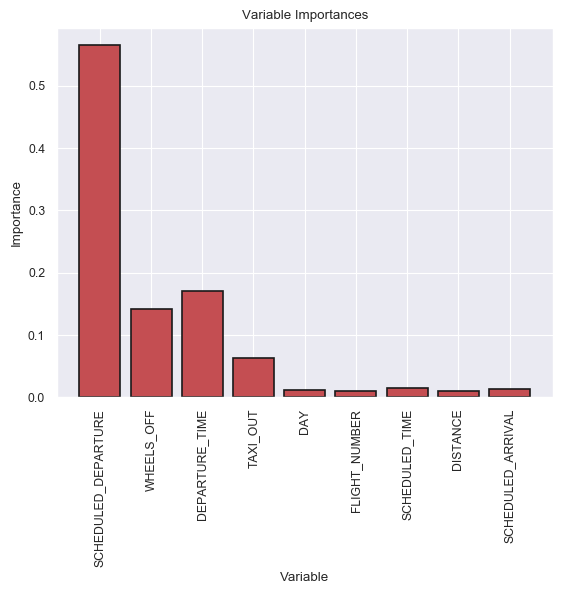

In [142]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

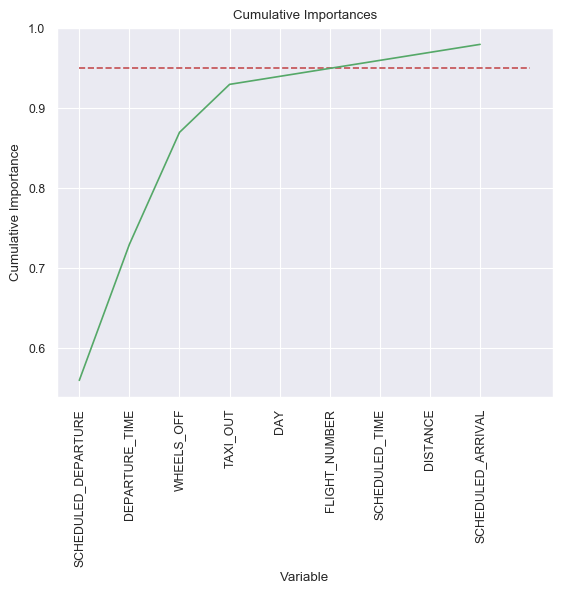

In [143]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [145]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 6


In [147]:
corr_test_matrix = df_train.corr()
corr_matrix['ARRIVAL_DELAY'].sort_values(ascending = False)

ARRIVAL_DELAY          1.000000
TAXI_OUT               0.238806
DEPARTURE_TIME         0.164384
WHEELS_OFF             0.160181
SCHEDULED_DEPARTURE    0.103083
SCHEDULED_ARRIVAL      0.092671
FLIGHT_NUMBER          0.017728
MONTH                  0.008731
id                     0.006280
DAY_OF_WEEK           -0.019053
DISTANCE              -0.023849
DAY                   -0.024166
SCHEDULED_TIME        -0.027254
YEAR                        NaN
Name: ARRIVAL_DELAY, dtype: float64

In [135]:
test_X = df_test.copy()
variables_to_remove_2 = ['id', 'AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'YEAR', 'MONTH']
test_X.drop(variables_to_remove_2, axis = 1, inplace=True)

In [136]:
test_X

,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
0,1,3,298,3,41.0,11.0,52.0,177.0,1222,500
1,1,3,1965,5,2400.0,21.0,21.0,303.0,2296,808
2,1,3,2020,5,2400.0,36.0,36.0,223.0,1619,548
3,1,3,612,5,53.0,14.0,107.0,178.0,1299,503
4,1,3,1044,8,17.0,20.0,37.0,364.0,2846,912
...,...,...,...,...,...,...,...,...,...,...
514379,31,5,919,2359,2356.0,12.0,8.0,248.0,1953,707
514380,31,5,1846,2359,12.0,10.0,22.0,274.0,2172,733
514381,31,5,682,2359,2355.0,14.0,9.0,213.0,1546,532
514382,31,5,300,2359,4.0,16.0,20.0,204.0,1506,523


In [137]:
test_X = test_X[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "DAY", "MONTH" 
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]

In [138]:
predicted_2 = reg_rf.predict(test_X)

In [139]:
print(predicted_2)

[ 26.52  -2.63 571.73 ... -11.77   1.9    2.37]


In [65]:
kaggle_submit = pd.read_csv('data\submit_sample.csv')
kaggle_submit['ARRIVAL_DELAY'] = predicted_2
kaggle_submit.to_csv('kaggle_submit.csv', index = False)

### 3.1.2 Best model (2nd - Improved a bit)

In [26]:
train_X = df_train[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "DAY",  
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]
train_Y = df_train.ARRIVAL_DELAY

In [209]:
start_time = time.time()

reg_rf = RandomForestRegressor(bootstrap = True)
reg_rf.fit(train_X, train_Y)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Elapsed time:  2340.750173330307


In [210]:
y_pred = reg_rf.predict(train_X)

In [211]:
reg_rf.score(train_X, train_Y)

0.9889405440708443

In [212]:
print('MAE:', metrics.mean_absolute_error(train_Y, y_pred))
print('MSE:', metrics.mean_squared_error(train_Y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_Y, y_pred)))

MAE: 2.5894259342428905
MSE: 18.275569457225107
RMSE: 4.274993503764082


In [213]:
feature_list = list(train_X.columns)

# Get numerical feature importances
importances = list(reg_rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SCHEDULED_DEPARTURE  Importance: 0.57
Variable: DEPARTURE_TIME       Importance: 0.17
Variable: WHEELS_OFF           Importance: 0.14
Variable: TAXI_OUT             Importance: 0.06
Variable: DAY                  Importance: 0.01
Variable: FLIGHT_NUMBER        Importance: 0.01
Variable: SCHEDULED_TIME       Importance: 0.01
Variable: DISTANCE             Importance: 0.01
Variable: SCHEDULED_ARRIVAL    Importance: 0.01


[None, None, None, None, None, None, None, None, None]

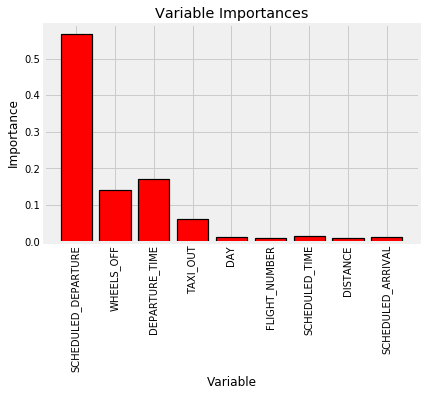

In [214]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

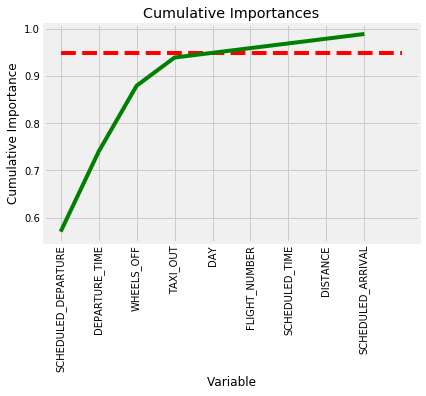

In [215]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [216]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 6


In [38]:
test_X = df_test[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "DAY",
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]

In [39]:
predicted_2 = reg_rf.predict(test_X)
print(predicted_2)

[ 24.54  -2.79 537.76 ... -11.79   3.16   2.41]


In [40]:
kaggle_submit = pd.read_csv('data\submit_sample.csv')
kaggle_submit['ARRIVAL_DELAY'] = predicted_2
kaggle_submit.to_csv('kaggle_submit.csv', index = False)

___
### 3.2 XGBoost
### 3.2.1 Best model (without one-hot encoding) 

In [200]:
train_X = df_train[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "DAY", 
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]
train_Y = df_train.ARRIVAL_DELAY

In [201]:
start_time = time.time()

model = XGBRegressor()
model.fit(train_X, train_Y)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Elapsed time:  113.66097021102905


In [202]:
y_pred = model.predict(train_X)

In [203]:
# Worse accuracy results on the train set (generalises better than random forest), but quicker to train 

model.score(train_X, train_Y)

0.9210996349164335

In [204]:
print('MAE:', metrics.mean_absolute_error(train_Y, y_pred))
print('MSE:', metrics.mean_squared_error(train_Y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_Y, y_pred)))

MAE: 7.692154004357524
MSE: 130.3815586880517
RMSE: 11.418474446617276


In [205]:
feature_list = list(train_X.columns)

# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SCHEDULED_DEPARTURE  Importance: 0.4699999988079071
Variable: DEPARTURE_TIME       Importance: 0.18000000715255737
Variable: WHEELS_OFF           Importance: 0.1599999964237213
Variable: TAXI_OUT             Importance: 0.14000000059604645
Variable: SCHEDULED_TIME       Importance: 0.019999999552965164
Variable: DAY                  Importance: 0.009999999776482582
Variable: DISTANCE             Importance: 0.009999999776482582
Variable: SCHEDULED_ARRIVAL    Importance: 0.009999999776482582
Variable: FLIGHT_NUMBER        Importance: 0.0


[None, None, None, None, None, None, None, None, None]

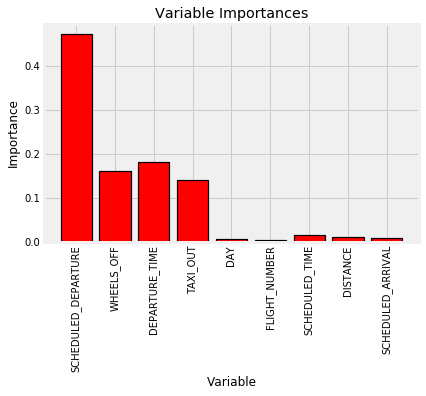

In [206]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

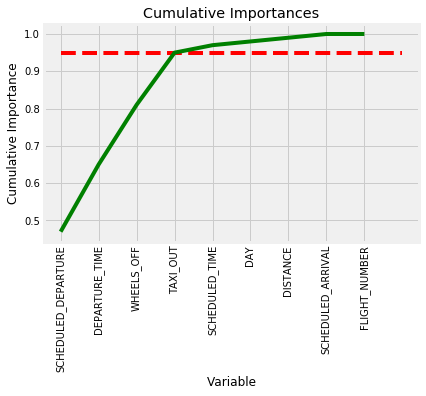

In [207]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [208]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 5


In [125]:
test_X = df_test[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "DAY", 
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]

In [126]:
predicted_2 = model.predict(test_X)

In [141]:
print(predicted_2)

[ 26.52  -2.63 571.73 ... -11.77   1.9    2.37]


In [140]:
kaggle_submit = pd.read_csv('data\submit_sample.csv')
kaggle_submit['ARRIVAL_DELAY'] = predicted_2
kaggle_submit.to_csv('kaggle_submit.csv', index = False)

___
### 3.3 CatBoost
### 3.3.1 Best model (1st attempt: 3rd highest score) 

In [219]:
train_X = df_train[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "DAY",  
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]
train_Y = df_train.ARRIVAL_DELAY

In [220]:
start_time = time.time()

cat = CatBoostRegressor()
cat.fit(train_X, train_Y)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Learning rate set to 0.143643
0:	learn: 39.0630633	total: 180ms	remaining: 2m 59s
1:	learn: 37.7020093	total: 298ms	remaining: 2m 28s
2:	learn: 36.2116248	total: 431ms	remaining: 2m 23s
3:	learn: 35.0144167	total: 588ms	remaining: 2m 26s
4:	learn: 34.0418636	total: 729ms	remaining: 2m 25s
5:	learn: 33.4254475	total: 867ms	remaining: 2m 23s
6:	learn: 32.5323803	total: 1.02s	remaining: 2m 24s
7:	learn: 31.8841627	total: 1.14s	remaining: 2m 21s
8:	learn: 30.8388141	total: 1.29s	remaining: 2m 21s
9:	learn: 30.5284550	total: 1.4s	remaining: 2m 18s
10:	learn: 29.7295672	total: 1.52s	remaining: 2m 17s
11:	learn: 29.0779412	total: 1.67s	remaining: 2m 17s
12:	learn: 28.8118774	total: 1.78s	remaining: 2m 14s
13:	learn: 27.8956395	total: 1.93s	remaining: 2m 15s
14:	learn: 27.7289716	total: 2.05s	remaining: 2m 14s
15:	learn: 27.0739775	total: 2.18s	remaining: 2m 14s
16:	learn: 26.5106543	total: 2.31s	remaining: 2m 13s
17:	learn: 25.7017010	total: 2.45s	remaining: 2m 13s
18:	learn: 25.3627487	total

In [223]:
y_pred = cat.predict(train_X)

In [224]:
# Worse training results, quicker to train and generalise better than random forest

cat.score(train_X, train_Y)

0.9283268234468799

In [221]:
print('MAE:', metrics.mean_absolute_error(train_Y, y_pred))
print('MSE:', metrics.mean_squared_error(train_Y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_Y, y_pred)))

MAE: 2.5894259342428905
MSE: 18.275569457225107
RMSE: 4.274993503764082


In [225]:
feature_list = list(train_X.columns)

# Get numerical feature importances
importances = list(cat.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SCHEDULED_DEPARTURE  Importance: 45.72
Variable: DEPARTURE_TIME       Importance: 24.0
Variable: WHEELS_OFF           Importance: 21.95
Variable: TAXI_OUT             Importance: 3.5
Variable: SCHEDULED_ARRIVAL    Importance: 3.11
Variable: SCHEDULED_TIME       Importance: 0.84
Variable: DISTANCE             Importance: 0.64
Variable: DAY                  Importance: 0.12
Variable: FLIGHT_NUMBER        Importance: 0.11


[None, None, None, None, None, None, None, None, None]

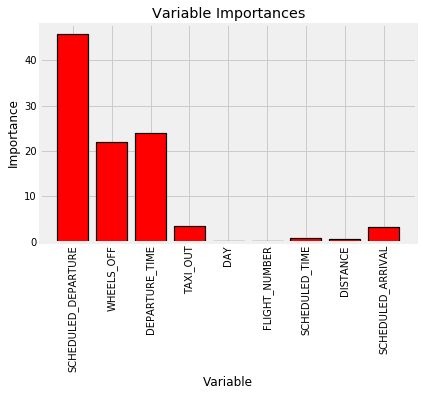

In [226]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

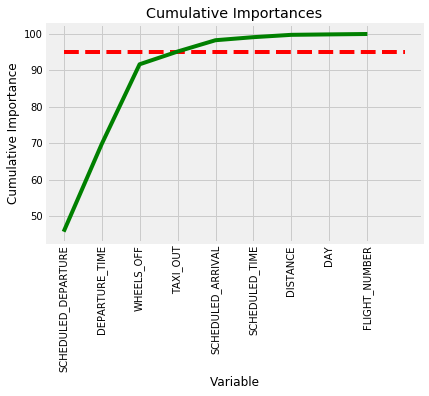

In [227]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin = 0, xmax = len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [228]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 4


In [40]:
test_X = df_test[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "DAY", 
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]

In [42]:
predicted_2 = cat.predict(test_X)
print(predicted_2)

[  5.34393132 -17.96702326  28.88207693 ...  -6.75755497  14.18637268
  -2.54329165]


In [43]:
kaggle_submit = pd.read_csv('data\submit_sample.csv')
kaggle_submit['ARRIVAL_DELAY'] = predicted_2
kaggle_submit.to_csv('kaggle_submit.csv', index = False)

### 3.3.2 Best model (2nd attempt: 2nd highest score) 

In [18]:
train_X = df_train[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "MONTH", "DAY",  
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]
train_Y = df_train.ARRIVAL_DELAY

In [19]:
start_time = time.time()

cat = CatBoostRegressor()
cat.fit(train_X, train_Y)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Learning rate set to 0.143643
0:	learn: 38.7973414	total: 297ms	remaining: 4m 56s
1:	learn: 37.5190073	total: 435ms	remaining: 3m 36s
2:	learn: 36.1457256	total: 627ms	remaining: 3m 28s
3:	learn: 34.8485413	total: 762ms	remaining: 3m 9s
4:	learn: 33.9435072	total: 890ms	remaining: 2m 57s
5:	learn: 33.3102808	total: 1.01s	remaining: 2m 46s
6:	learn: 32.0788370	total: 1.17s	remaining: 2m 45s
7:	learn: 31.4878229	total: 1.29s	remaining: 2m 40s
8:	learn: 30.7713400	total: 1.46s	remaining: 2m 40s
9:	learn: 30.1935935	total: 1.6s	remaining: 2m 38s
10:	learn: 29.1029813	total: 1.76s	remaining: 2m 38s
11:	learn: 28.7633309	total: 1.88s	remaining: 2m 34s
12:	learn: 28.4784645	total: 2s	remaining: 2m 31s
13:	learn: 27.7693742	total: 2.15s	remaining: 2m 31s
14:	learn: 27.2496310	total: 2.29s	remaining: 2m 30s
15:	learn: 26.6436481	total: 2.42s	remaining: 2m 29s
16:	learn: 25.8768651	total: 2.6s	remaining: 2m 30s
17:	learn: 25.3444027	total: 2.75s	remaining: 2m 29s
18:	learn: 24.9304946	total: 2.8

In [20]:
y_pred = cat.predict(train_X)

In [21]:
cat.score(train_X, train_Y)

0.9298329515409609

In [22]:
print('MAE:', metrics.mean_absolute_error(train_Y, y_pred))
print('MSE:', metrics.mean_squared_error(train_Y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_Y, y_pred)))

MAE: 7.140636818050004
MSE: 115.9498962639785
RMSE: 10.76800335549625


In [23]:
feature_list = list(train_X.columns)

# Get numerical feature importances
importances = list(cat.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SCHEDULED_DEPARTURE  Importance: 46.79
Variable: DEPARTURE_TIME       Importance: 25.92
Variable: WHEELS_OFF           Importance: 20.15
Variable: TAXI_OUT             Importance: 3.23
Variable: SCHEDULED_ARRIVAL    Importance: 1.63
Variable: SCHEDULED_TIME       Importance: 0.92
Variable: DISTANCE             Importance: 0.7
Variable: MONTH                Importance: 0.28
Variable: DAY                  Importance: 0.27
Variable: FLIGHT_NUMBER        Importance: 0.12


[None, None, None, None, None, None, None, None, None, None]

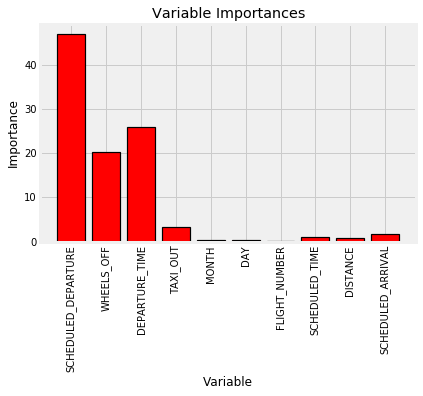

In [24]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

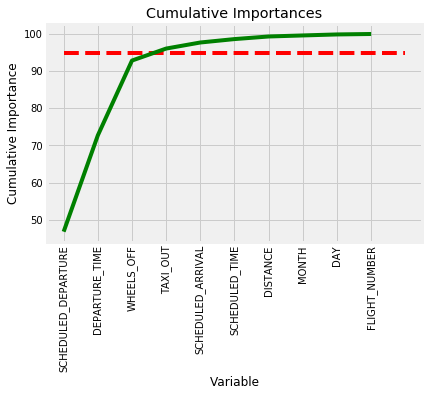

In [25]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin = 0, xmax = len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [26]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 4


In [54]:
test_X = df_test[["SCHEDULED_DEPARTURE", "WHEELS_OFF", "DEPARTURE_TIME", "TAXI_OUT", "MONTH", "DAY",
                 "FLIGHT_NUMBER", "SCHEDULED_TIME", "DISTANCE", "SCHEDULED_ARRIVAL"]]

In [55]:
predicted_2 = cat.predict(test_X)
print(predicted_2)

[ 4.27033831  0.86576541 47.43771832 ... -3.17216468 16.40781916
 -0.24700572]


In [56]:
kaggle_submit = pd.read_csv('data\submit_sample.csv')
kaggle_submit['ARRIVAL_DELAY'] = predicted_2
kaggle_submit.to_csv('kaggle_submit.csv', index = False)

### 3.4 Conclusion

Based on the performed tests, performance metrics, and computation time, it is decided to go with the CatBoost models as final model. CatBoost generalises well on both the test and train sets, training time is quick, and has a high performance in comparison to Random forest and XGBoost. 

## 4.1 Final model
### 4.1.1 First attempt (with one-hot encoding - highest score)

In [28]:
train_X = df_train.drop(["id", "DAY_OF_WEEK", "ARRIVAL_DELAY", "TAIL_NUMBER", "YEAR"], axis=1)
train_Y = df_train.ARRIVAL_DELAY

In [29]:
categorical = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

In [30]:
start_time = time.time()

cat = CatBoostRegressor()
cat.fit(train_X, train_Y, cat_features = categorical)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Learning rate set to 0.143643
0:	learn: 38.7784997	total: 855ms	remaining: 14m 14s
1:	learn: 37.1254038	total: 1.62s	remaining: 13m 26s
2:	learn: 35.9129139	total: 2.6s	remaining: 14m 23s
3:	learn: 34.7311077	total: 3.51s	remaining: 14m 35s
4:	learn: 33.8008302	total: 4.44s	remaining: 14m 44s
5:	learn: 33.1708134	total: 5.33s	remaining: 14m 43s
6:	learn: 31.9749148	total: 6.26s	remaining: 14m 47s
7:	learn: 31.5441170	total: 7.04s	remaining: 14m 32s
8:	learn: 30.5680871	total: 7.93s	remaining: 14m 33s
9:	learn: 29.6413910	total: 8.78s	remaining: 14m 29s
10:	learn: 29.3527343	total: 9.77s	remaining: 14m 38s
11:	learn: 28.6639985	total: 11.2s	remaining: 15m 24s
12:	learn: 28.4593715	total: 12.5s	remaining: 15m 46s
13:	learn: 27.5708515	total: 13.9s	remaining: 16m 20s
14:	learn: 27.0574909	total: 15.4s	remaining: 16m 49s
15:	learn: 26.4653838	total: 16.6s	remaining: 17m
16:	learn: 25.7638352	total: 18.2s	remaining: 17m 30s
17:	learn: 25.5582915	total: 19.4s	remaining: 17m 39s
18:	learn: 25

In [31]:
y_pred = cat.predict(train_X)

In [32]:
cat.score(train_X, train_Y)

0.9353348327483537

In [33]:
print('MAE:', metrics.mean_absolute_error(train_Y, y_pred))
print('MSE:', metrics.mean_squared_error(train_Y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_Y, y_pred)))

MAE: 6.767055708669385
MSE: 106.85812784469927
RMSE: 10.337220508661856


In [34]:
feature_list = list(train_X.columns)

# Get numerical feature importances
importances = list(cat.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SCHEDULED_DEPARTURE  Importance: 45.95
Variable: DEPARTURE_TIME       Importance: 25.5
Variable: WHEELS_OFF           Importance: 21.1
Variable: TAXI_OUT             Importance: 3.61
Variable: SCHEDULED_ARRIVAL    Importance: 0.72
Variable: SCHEDULED_TIME       Importance: 0.66
Variable: AIRLINE              Importance: 0.56
Variable: MONTH                Importance: 0.43
Variable: DISTANCE             Importance: 0.43
Variable: ORIGIN_AIRPORT       Importance: 0.41
Variable: DAY                  Importance: 0.35
Variable: DESTINATION_AIRPORT  Importance: 0.25
Variable: FLIGHT_NUMBER        Importance: 0.03


[None, None, None, None, None, None, None, None, None, None, None, None, None]

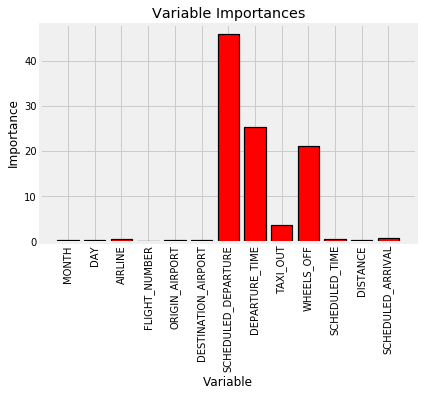

In [35]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

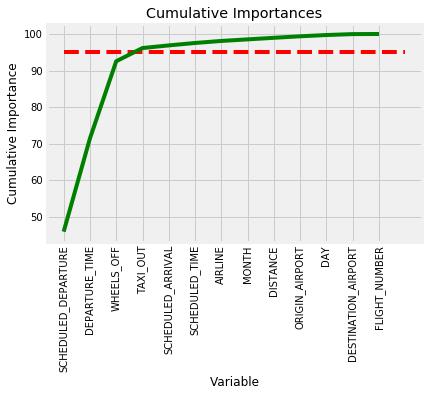

In [36]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [38]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 4


In [41]:
test_X = df_test.drop(["id", "DAY_OF_WEEK", "TAIL_NUMBER", "YEAR"], axis=1)

In [44]:
predicted_2 = cat.predict(test_X)
print(predicted_2)

[ 4.99813731  0.58065512 55.67223725 ... -3.18322138 18.65743999
 -2.06137043]


In [45]:
kaggle_submit = pd.read_csv('data\submit_sample.csv')
kaggle_submit['ARRIVAL_DELAY'] = predicted_2
kaggle_submit.to_csv('kaggle_submit.csv', index = False)

### 4.1.2 Second attempt (with one-hot encoding + iterations tuning = 2nd best score: 94.32788)

In [17]:
train_X = df_train.drop(["id", "DAY_OF_WEEK", "ARRIVAL_DELAY", "TAIL_NUMBER", "YEAR"], axis=1)
train_Y = df_train.ARRIVAL_DELAY

In [18]:
categorical = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

In [173]:
# Higher l2_leaf_reg & higher depth results in higher MSE

start_time = time.time()

cat = CatBoostRegressor(iterations = 1400)

cat.fit(train_X, train_Y, cat_features = categorical, use_best_model = True)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.109265
0:	learn: 39.2081861	total: 752ms	remaining: 17m 31s
1:	learn: 37.8980718	total: 1.49s	remaining: 17m 23s
2:	learn: 36.8944443	total: 2.32s	remaining: 17m 58s
3:	learn: 36.0477512	total: 3.12s	remaining: 18m 8s
4:	learn: 35.1017677	total: 3.9s	remaining: 18m 9s
5:	learn: 34.4052690	total: 4.76s	remaining: 18m 25s
6:	learn: 33.8632400	total: 5.58s	remaining: 18m 30s
7:	learn: 33.1742107	total: 6.33s	remaining: 18m 21s
8:	learn: 32.7545416	total: 7.08s	remaining: 18m 13s
9:	learn: 31.8518708	total: 7.88s	remaining: 18m 15s
10:	learn: 31.2323691	total: 8.63s	remaining: 18m 9s
11:	learn: 30.8383121	total: 9.54s	remaining: 18m 23s
12:	learn: 30.4725090	total: 10.3s	remaining: 18m 20s
13:	learn: 29.6631635	total: 11.1s	remaining: 18m 21s
14:	learn: 29.0550039	total: 12.1s	remaining: 18m 34s
15:	learn: 28.7813912	total: 12.8s	remaining: 18m 31s
16:	learn: 28.0448360	total: 13.7s	remaining: 18m 38s
17:	learn: 27.8193846	total: 14.7s	remaining: 18m 52s
18:	learn: 2

In [174]:
cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1400,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

In [178]:
y_pred = cat.predict(train_X)

In [179]:
cat.score(train_X, train_Y)

0.9370655296187915

In [180]:
print('MAE:', metrics.mean_absolute_error(train_Y, y_pred))
print('MSE:', metrics.mean_squared_error(train_Y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_Y, y_pred)))

MAE: 6.667291921736946
MSE: 103.99817966391187
RMSE: 10.197949777475465


In [181]:
feature_list = list(train_X.columns)

# Get numerical feature importances
importances = list(cat.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SCHEDULED_DEPARTURE  Importance: 46.71
Variable: DEPARTURE_TIME       Importance: 24.64
Variable: WHEELS_OFF           Importance: 20.09
Variable: TAXI_OUT             Importance: 3.5
Variable: SCHEDULED_ARRIVAL    Importance: 1.87
Variable: SCHEDULED_TIME       Importance: 0.67
Variable: AIRLINE              Importance: 0.52
Variable: DISTANCE             Importance: 0.45
Variable: MONTH                Importance: 0.43
Variable: ORIGIN_AIRPORT       Importance: 0.43
Variable: DAY                  Importance: 0.37
Variable: DESTINATION_AIRPORT  Importance: 0.26
Variable: FLIGHT_NUMBER        Importance: 0.05


[None, None, None, None, None, None, None, None, None, None, None, None, None]

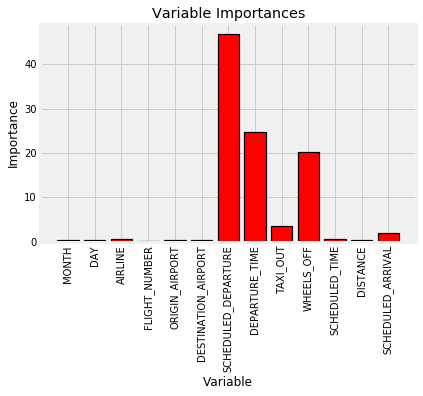

In [182]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

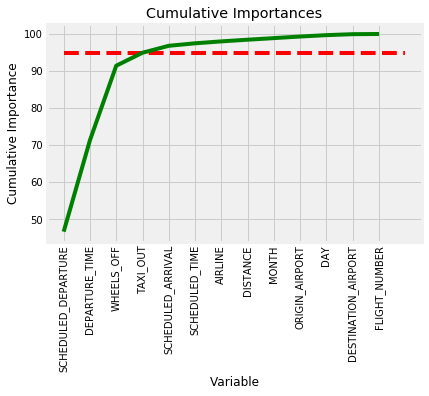

In [183]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [184]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 5


In [185]:
test_X = df_test.drop(["id", "DAY_OF_WEEK", "TAIL_NUMBER", "YEAR"], axis=1)

In [186]:
predicted_2 = cat.predict(test_X)
print(predicted_2)

[ 1.30858592  5.23173911 53.38185515 ... -1.57791881 18.99399498
 -0.0858772 ]


In [187]:
kaggle_submit = pd.read_csv('data\submit_sample.csv')
kaggle_submit['ARRIVAL_DELAY'] = predicted_2
kaggle_submit.to_csv('kaggle_submit.csv', index = False)

### 4.1.3 Third attempt (with one-hot encoding + iterations tuning (+50 in comparison with previous attempt) + creation of DEPARTURE_DELAY = best score: 92.35631)

In [83]:
df_train['DEPARTURE_DELAY'] = 0
df_train['DEPARTURE_DELAY'] = df_train['DEPARTURE_TIME'] - df_train['SCHEDULED_DEPARTURE']
df_train['DEPARTURE_DELAY'][df_train['DEPARTURE_DELAY'] > 1200] = 2400 - df_train['SCHEDULED_DEPARTURE'] - df_train['DEPARTURE_TIME']
df_train['DEPARTURE_DELAY'][df_train['DEPARTURE_DELAY'] < -1200] = 2400 - df_train['SCHEDULED_DEPARTURE'] + df_train['DEPARTURE_TIME']

In [84]:
df_train

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DEPARTURE_DELAY
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0,41.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0,-8.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0,-2.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0,-5.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2818548,2015,6,30,2,UA,1180,N65832,LAX,ORD,2359,2358.0,11.0,9.0,241.0,1744,600,-8.0,-1.0
2818549,2818549,2015,6,30,2,UA,1192,N69839,LAX,IAH,2359,129.0,11.0,140.0,201.0,1379,520,79.0,170.0
2818550,2818550,2015,6,30,2,UA,1480,N37298,PDX,IAH,2359,152.0,8.0,200.0,249.0,1825,608,107.0,193.0
2818551,2818551,2015,6,30,2,UA,1637,N35260,SEA,IAH,2359,12.0,12.0,24.0,250.0,1874,609,9.0,53.0


In [85]:
train_X = df_train.drop(["id", "DAY_OF_WEEK", "ARRIVAL_DELAY", "TAIL_NUMBER", "YEAR"], axis=1)
train_Y = df_train.ARRIVAL_DELAY

In [86]:
categorical = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

In [87]:
# Higher l2_leaf_reg & higher depth results in higher MSE

start_time = time.time()

cat = CatBoostRegressor(iterations = 1450)

cat.fit(train_X, train_Y, cat_features = categorical, use_best_model = True)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.106192
0:	learn: 37.3927757	total: 870ms	remaining: 21m 1s
1:	learn: 34.5240407	total: 1.82s	remaining: 21m 56s
2:	learn: 31.9856654	total: 2.8s	remaining: 22m 32s
3:	learn: 29.6315215	total: 3.83s	remaining: 23m 4s
4:	learn: 27.6849175	total: 4.97s	remaining: 23m 55s
5:	learn: 25.9570073	total: 6.49s	remaining: 26m 1s
6:	learn: 24.4409981	total: 7.74s	remaining: 26m 36s
7:	learn: 23.0298662	total: 9.2s	remaining: 27m 38s
8:	learn: 21.8820014	total: 10.4s	remaining: 27m 49s
9:	learn: 20.9177455	total: 11.9s	remaining: 28m 31s
10:	learn: 19.9607084	total: 13.8s	remaining: 30m 2s
11:	learn: 19.2210072	total: 15.1s	remaining: 30m 4s
12:	learn: 18.6064486	total: 16.6s	remaining: 30m 30s
13:	learn: 18.0627632	total: 18.2s	remaining: 31m 1s
14:	learn: 17.6056092	total: 19.8s	remaining: 31m 37s
15:	learn: 17.2222845	total: 21.5s	remaining: 32m 6s
16:	learn: 16.7455627	total: 23.2s	remaining: 32m 38s
17:	learn: 16.3312246	total: 24.7s	remaining: 32m 47s
18:	learn: 16.051

In [24]:
cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1450,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

In [89]:
y_pred = cat.predict(train_X)

In [90]:
cat.score(train_X, train_Y)

0.940157142430815

In [88]:
print('MAE:', metrics.mean_absolute_error(train_Y, y_pred))
print('MSE:', metrics.mean_squared_error(train_Y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_Y, y_pred)))

MAE: 6.813533798998801
MSE: 110.58828955989063
RMSE: 10.516096688405382


In [27]:
feature_list = list(train_X.columns)

# Get numerical feature importances
importances = list(cat.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: DEPARTURE_DELAY      Importance: 72.04
Variable: TAXI_OUT             Importance: 8.75
Variable: SCHEDULED_DEPARTURE  Importance: 3.54
Variable: SCHEDULED_TIME       Importance: 3.11
Variable: DEPARTURE_TIME       Importance: 2.38
Variable: AIRLINE              Importance: 1.98
Variable: WHEELS_OFF           Importance: 1.8
Variable: ORIGIN_AIRPORT       Importance: 1.5
Variable: DISTANCE             Importance: 1.31
Variable: MONTH                Importance: 0.98
Variable: DESTINATION_AIRPORT  Importance: 0.96
Variable: DAY                  Importance: 0.86
Variable: SCHEDULED_ARRIVAL    Importance: 0.55
Variable: FLIGHT_NUMBER        Importance: 0.22


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

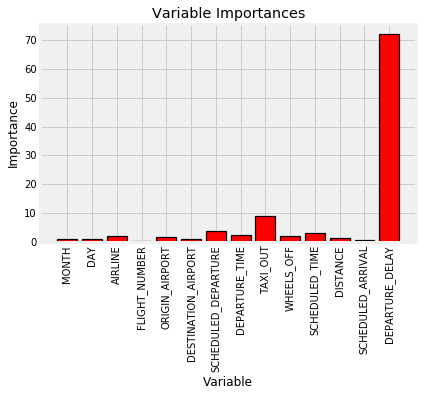

In [28]:
# List of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

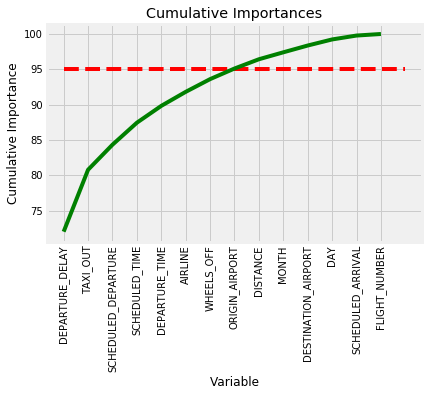

In [29]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [30]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 8


In [31]:
# Creation DEPARTURE_DELAY in the test_set

df_test['DEPARTURE_DELAY'] = 0
df_test['DEPARTURE_DELAY'] = df_test['DEPARTURE_TIME'] - df_test['SCHEDULED_DEPARTURE']
df_test['DEPARTURE_DELAY'][df_test['DEPARTURE_DELAY'] > 1200] = 2400 - df_test['SCHEDULED_DEPARTURE'] - df_test['DEPARTURE_TIME']
df_test['DEPARTURE_DELAY'][df_test['DEPARTURE_DELAY'] < -1200] = 2400 - df_test['SCHEDULED_DEPARTURE'] + df_test['DEPARTURE_TIME']

In [32]:
test_X = df_test.drop(["id", "DAY_OF_WEEK", "TAIL_NUMBER", "YEAR"], axis=1)

In [33]:
predicted_2 = cat.predict(test_X)
print(predicted_2)

[27.71658885  5.93559175 12.13629287 ... -2.10754407 11.04281185
  5.02028386]


In [34]:
kaggle_submit = pd.read_csv('data\submit_sample.csv')
kaggle_submit['ARRIVAL_DELAY'] = predicted_2
kaggle_submit.to_csv('kaggle_submit.csv', index = False)